In [64]:
pip install googletrans

In [0]:
import os
os.chdir('drive/My Drive/Dataset/CodeMixed')
!ls

Data		    IIITH_Codemixed.txt   translated_data.txt
embeddings_dict.h5  Padded_Embeddings.h5  y_train.h5
glove.6B.100d.txt   pygoogletransmaster


In [0]:
import numpy as np
import h5py
import pickle
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.callbacks import Callback,ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import sequence
from keras.optimizers import Adamax
from keras import backend as K
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from google.cloud import translate_v2
from keras.utils import np_utils
from googletrans import Translator
import matplotlib.pyplot as plt
import pandas as pd
import re

In [0]:
################# GLOBAL VARIABLES #####################
#Filenames
Masterdir = ''
translated_data = 'translated_data.txt'
embeddings_dict = {}
check_dict = {}
max_length = 50

In [0]:
#LSTM Model Hyperparameters
lstm_parameters_size = 128
# Training Hyperparameters
batch_size = 64
num_epochs = 50
num_classes = 3
fraction_test_set = 0.2

In [0]:
def token(sentence, remove_vowels=False, remove_repeat=False, minchars=2):
    tokens = []
    #for t in re.findall("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\w]+",sentence.lower()):
    for t in re.findall("[a-zA-Z]+",sentence.lower()):

        if len(t)>=minchars:
            if remove_vowels:
                t=removeVovels(t)
            if remove_repeat:
                t=removeRepeat(t)
            tokens.append(t)
    return tokens

In [0]:
def load_embeddings():
	"""
	Purpose -> It Loads the pretrained GloVe Word Embeddings
	Input   -> No Arguments
	Output  -> Loads the Embeddings into Embeddings_dict
	"""
	f = open("glove.6B.100d.txt", 'r', encoding="utf-8")

	for line in f:
	    values = line.split()
	    word = values[0]
	    vector = np.asarray(values[1:], "float32")
	    embeddings_dict[word] = vector
	    check_dict[word] = 1


In [0]:
def save_data(Masterdir,data_name, data, file_name):
	"""
	Purpose -> Saves the data along with labels as data_name in the folder Masterdir.
	Input   -> Data, Folder location where and Data is stored in file File_name
	Output  -> Nil
	"""
	h5f = h5py.File(Masterdir+Modeldir+file_name+'.h5', 'a')
	h5f.create_dataset(data_name, data=data)
	h5f.close()

In [0]:
def save_model(Masterdir,filename,model):
	"""
	Purpose -> Saves the model along with labels as data_name in the folder Masterdir.
	Input   -> Keras model along with the location of file where it is to be stored.
	Output  -> Nil
	"""
	#Referred from:- http://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
	model.save(Masterdir+'LSTM_'+filename+'_model.h5')
	model.save_weights(Masterdir+'LSTM_'+filename+'_weights.h5')

In [0]:
def get_data(Masterdir, filename, data_name):
  """
	Purpose -> It is used to get data stored in an h5py file.
	Input   -> Filename, folder location and the key name in h5py file.
	Output  -> Extracted Data
	"""
  h5f = h5py.File(Masterdir+filename+'.h5', 'r')
  return h5f[data_name]

In [0]:
def get_f1(y_true, y_pred): #taken from old keras source code
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
def create_embedding_vectors(Masterdir,filename):
	"""
	Purpose -> Get Word Embeddings and pad the sequence
	Input   -> Data file containing the list of words
	Output  -> A feature matrix representing embedding vectors of words.
	"""
	f=open(Masterdir+Datadir+filename,'r', encoding='utf-8')
	lines = f.read()
	lines = lines.split('\n')

	temp = np.random.randn(100)
	embeddings = []
	mx=0

	for line in lines:
		token_lines = token(line)

		embedding_vector = []
		for words in token_lines:
			value = check_dict.get(words)
			if(value != None):
				vector = embeddings_dict.get(words)
				#print("vector shape: ",vector.shape)
				embedding_vector.append(vector)
			else:
				embedding_vector.append(temp)

		size = len(embedding_vector)
		mx = max(mx,size)
		for i in range(max_length-size):
			embedding_vector.append(temp)
	 
		embedding_vector = np.asarray(embedding_vector)
		embeddings.append(embedding_vector[0:max_length])
		#print("embedding_vector shape : ", embedding_vector.shape)
	
	embeddings = np.asarray(embeddings)
	print(embeddings.shape)
	return embeddings

In [0]:
def RNN_Model_Helper(X_train,y_train,hyperparameters):
	"""
	Purpose -> It Defines and trains the proposed Keras LSTM model
	Input   -> Training data, label and respective Hyperparameters.
	Output  -> Trained LSTM network and its history
	"""
	#Sets the model hyperparameters
	# LSTM hyperparameters
	lstm_parameters_size = hyperparameters[6]
	# Training hyperparameters
	batch_size = hyperparameters[7]
	nb_epoch = hyperparameters[8]
	num_classes = hyperparameters[9]
	fraction_test_set = hyperparameters[10] 

	#Train & Validation data splitting
	X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=1-fraction_test_set, fraction_test_set=fraction_test_set, random_state=42)
	
	#Build the sequential model
	print('Build model...')
	model = Sequential()

	model.add(LSTM(lstm_parameters_size, return_sequences=True))
	#model.add(LSTM(lstm_parameters_size, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
	model.add(LSTM(lstm_parameters_size, return_sequences=False))
	model.add(Dense(num_classes))
	model.add(Activation('softmax'))

	#Adamax Optimizer is used and loss model is categorical crossentropy loss
	model.compile(loss='categorical_crossentropy',
			  	optimizer='adamax',
			  	metrics=['accuracy'])
	

	print('Train...')
	#Model is trained for 50 epochs and shuffled after every epoch for training data, model is validated on validation data
	history = model.fit(X_train, y_train, 
			  batch_size=batch_size, 
			  shuffle=True, 
			  epochs=nb_epoch,
			  validation_data=(X_valid, y_valid))
 
	return model,history

In [0]:
def evaluate_model(X_test,y_test,model,batch_size,num_classes):
	"""
	Purpose -> It is used to evaluate the model on the testing data.
	Input   -> Testing data and its corresponding label, trained model.
	Output  -> Nil
	"""
	#Evaluate the accuracies
	score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
	print('Test score:', score)
	print('Test accuracy:', acc)

In [0]:
def print_training_losses(history):
  """
	Purpose -> To Plot a graph of Loss versus Epochs during Training
	Input   -> Keras history variable that contain information related to losses.
	Output  -> Nil
	"""
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [0]:
def print_training_accuracy(history):
  """
	Purpose -> To Plot a graph of Accuracy versus Epochs during Training
	Input   -> Keras history variable that contain information related to Model's Accuracy.
	Output  -> Nil
	"""
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']
  epochs = range(1, num_epochs+1)
  plt.plot(epochs, acc_train, 'g', label='Training accuracy')
  plt.plot(epochs, acc_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

Loading GloVe Embeddings...
GloVe Embeddings Loaded Successfully...
Creating Embedding Vectors...
(2592, 50, 100)
[-0.6817311  -0.6276674   1.5813818  -0.26463943  1.07578199  1.53975185
  0.38356503 -0.45795856  1.19999037  0.47646645 -0.14965938 -0.74445103
  0.18443522 -1.87224724 -0.23803342  0.44471928 -1.03011412 -0.07037603
 -0.01377655  0.1949169   0.89693354 -0.61337502  2.72201472  0.57278129
 -1.81080483 -0.33751135 -0.22812751  0.06899858 -1.11148951  0.13577785
  0.5081188  -0.00386324  0.92051186  0.18114805 -1.15111909  1.14354005
  0.28803396  1.68312451  1.47037131 -0.96676225 -0.13011999 -0.73528063
  1.34348181 -0.52281293 -0.22839533 -0.05239034  0.06135805  1.08642423
  0.14646381  0.04605178  0.10094235 -0.60921943 -0.13128605  1.50028154
 -0.7065093   0.22511454  0.33837259  0.39208676  1.07505199 -0.09933878
 -0.21442647  0.47744288 -0.4144244   0.62974039 -0.30872554 -0.70870322
 -1.34085519  0.69801417  0.05462367  0.64955344  1.75895274  0.85509457
  0.385755

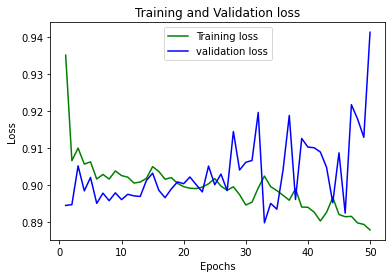

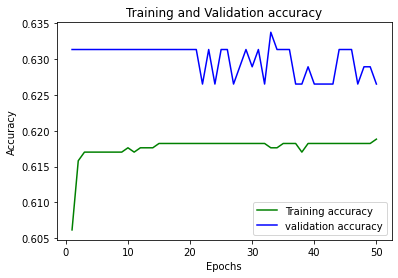

Evaluating model...
519/519 [==============================] - 1s 1ms/step
Test score: 0.8694907931004415
Test accuracy: 0.6570327281951904
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 128)           117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 249,219
Trainable params: 249,219
Non-trainable params: 0
_________________________________________________________________


In [80]:
if __name__ == '__main__':

  #Master function
  print('Loading GloVe Embeddings...')
  load_embeddings()
  print('GloVe Embeddings Loaded Successfully...')
  print('Creating Embedding Vectors...')
  embeddings = create_embedding_vectors(Masterdir,translated_data)
  print(embeddings[0][max_length-1])
  print('Embedding Vectors Created...')
  save_data(Masterdir,"Padded_Embeddings", embeddings, "Padded_Embeddings")

  X_train = get_data(Masterdir, "Padded_Embeddings", "Padded_Embeddings")
  X_train = np.array(X_train)
  y_train = get_data(Masterdir, "y_train", "y_train")
  y_train = np.asarray(np_utils.to_categorical(y_train, num_classes))[0:X_train.shape[0],:]
  #y_train = np.asarray(y_train).flatten()[0:X_train.shape[0]]
  print(y_train.shape)
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=1-fraction_test_set, fraction_test_set=fraction_test_set, random_state=42)

  save_data(Masterdir,"X_train", X_train, "Train_Data")
  save_data(Masterdir,"X_test", X_test, "Test_Data")
  save_data(Masterdir,"y_train", y_train, "Train_Data")
  save_data(Masterdir,"y_test", y_test, "Test_Data")

  print('Creating LSTM Network...')
  model,history = RNN_Model_Helper(deepcopy(X_train),deepcopy(y_train),[MAX_FEATURES, max_length, embedding_size, filter_length, nb_filter, pool_length, lstm_parameters_size, batch_size, num_epochs, num_classes, fraction_test_set])

  print('Plot Training/Validation Curves...')
  print_training_losses(history)
  print_training_accuracy(history)

  save_model(Masterdir, "Keras", model)
  print('Evaluating model...')
  evaluate_model(X_test,deepcopy(y_test),model,batch_size,num_classes)
  model.summary()